# Baseline Model Training (Random)

In [40]:
import pickle
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

# Load dataset (Temporal Split)

# with open("train_val_test_time.pkl", "rb") as f:
#    X_train_time, X_val_time, X_test_time, y_train_time, y_val_time, y_test_time = pickle.load(f)

# print("Data (Time) successfully loaded!")

# Load dataset (Random Split)
with open("train_val_test_random.pkl", "rb") as f:
    X_train_rand, X_val_rand, X_test_rand, y_train_rand, y_val_rand, y_test_rand = pickle.load(f)

print("Data (Random) successfully loaded!")


Data (Random) successfully loaded!


In [41]:
# Convert categorical features to category dtype for XGBoost
categorical_features = ["emp_length"]  # 'purpose' was already one-hot encoded



# Optionally include auto-detection of purpose_* columns
purpose_columns = [col for col in X_train_rand.columns if col.startswith("purpose_")]
categorical_features += purpose_columns  # if you want to explicitly tag them (optional)


# Drop them from all feature splits
X_train_rand = X_train_rand.drop(columns=purpose_columns)
X_val_rand = X_val_rand.drop(columns=purpose_columns)
X_test_rand = X_test_rand.drop(columns=purpose_columns)

print("✅ Dropped purpose_* columns from feature sets.")

# Apply dtype conversion safely
for col in categorical_features:
    for df_ in [X_train_rand, X_val_rand, X_test_rand]:
        if col in df_.columns:
            df_[col] = df_[col].astype("category")

print("✅ Categorical processing complete.")




✅ Dropped purpose_* columns from feature sets.
✅ Categorical processing complete.


In [42]:
print(X_train_rand.dtypes.to_string())

total_bal_ex_mort              float64
bc_open_to_buy                 float64
total_cu_tl                    float64
num_bc_sats                    float64
fico_range_high                float64
pub_rec_bankruptcies           float64
installment                    float64
total_bal_il                   float64
num_rev_tl_bal_gt_0            float64
total_il_high_credit_limit     float64
tot_cur_bal                    float64
percent_bc_gt_75               float64
inq_last_12m                   float64
mort_acc                       float64
annual_inc                     float64
mths_since_recent_inq          float64
delinq_2yrs                    float64
num_op_rev_tl                  float64
mths_since_recent_bc           float64
purpose                          int64
application_type                 int64
num_rev_accts                  float64
mo_sin_rcnt_rev_tl_op          float64
max_bal_bc                     float64
num_bc_tl                      float64
avg_cur_bal              

In [43]:
import xgboost as xgb
import numpy as np

# Calculate class imbalance for proper weighting
class_counts = np.bincount(y_train_rand)
print(f"Class distribution: {class_counts}")
# scale_pos_weight gives more weight to the minority class (defaults)
scale_pos_weight = class_counts[0] / class_counts[1]
print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")

# Initialize XGBoost classifier with evaluation enabled
xgb_model_rand = xgb.XGBClassifier(
    objective="multi:softmax",  
    num_class=len(y_train_rand.unique()),  
    tree_method="hist",  
    enable_categorical=True,  
    use_label_encoder=False,  
    reg_alpha=5,  
    reg_lambda=2,  
    learning_rate=0.05,  
    max_depth=4,  
    min_child_weight=3,  
    n_estimators=500,  
    early_stopping_rounds=450,  
    eval_metric=["mlogloss", "merror", "auc"],
    scale_pos_weight=scale_pos_weight,
)

# ✅ Train the model with evaluation enabled
xgb_model_rand.fit(
    X_train_rand, y_train_rand,
    eval_set=[(X_train_rand, y_train_rand), (X_val_rand, y_val_rand)],  # Use train & validation set
    verbose=True  # Show progress
)

print("✅ Model training complete with evaluation results.")


Class distribution: [ 196672 1367486]
Calculated scale_pos_weight: 0.14


/Users/jiaxuanliu/anaconda3/envs/math170/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:58:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:0.66519	validation_0-merror:0.12574	validation_0-auc:0.64538	validation_1-mlogloss:0.66517	validation_1-merror:0.12544	validation_1-auc:0.64332
[1]	validation_0-mlogloss:0.63992	validation_0-merror:0.12574	validation_0-auc:0.65129	validation_1-mlogloss:0.63988	validation_1-merror:0.12544	validation_1-auc:0.64972
[2]	validation_0-mlogloss:0.61699	validation_0-merror:0.12574	validation_0-auc:0.65519	validation_1-mlogloss:0.61694	validation_1-merror:0.12544	validation_1-auc:0.65402
[3]	validation_0-mlogloss:0.59614	validation_0-merror:0.12574	validation_0-auc:0.65685	validation_1-mlogloss:0.59607	validation_1-merror:0.12544	validation_1-auc:0.65572
[4]	validation_0-mlogloss:0.57714	validation_0-merror:0.12574	validation_0-auc:0.65758	validation_1-mlogloss:0.57706	validation_1-merror:0.12544	validation_1-auc:0.65642
[5]	validation_0-mlogloss:0.55979	validation_0-merror:0.12574	validation_0-auc:0.65918	validation_1-mlogloss:0.55969	validation_1-merror:0.12544	valid

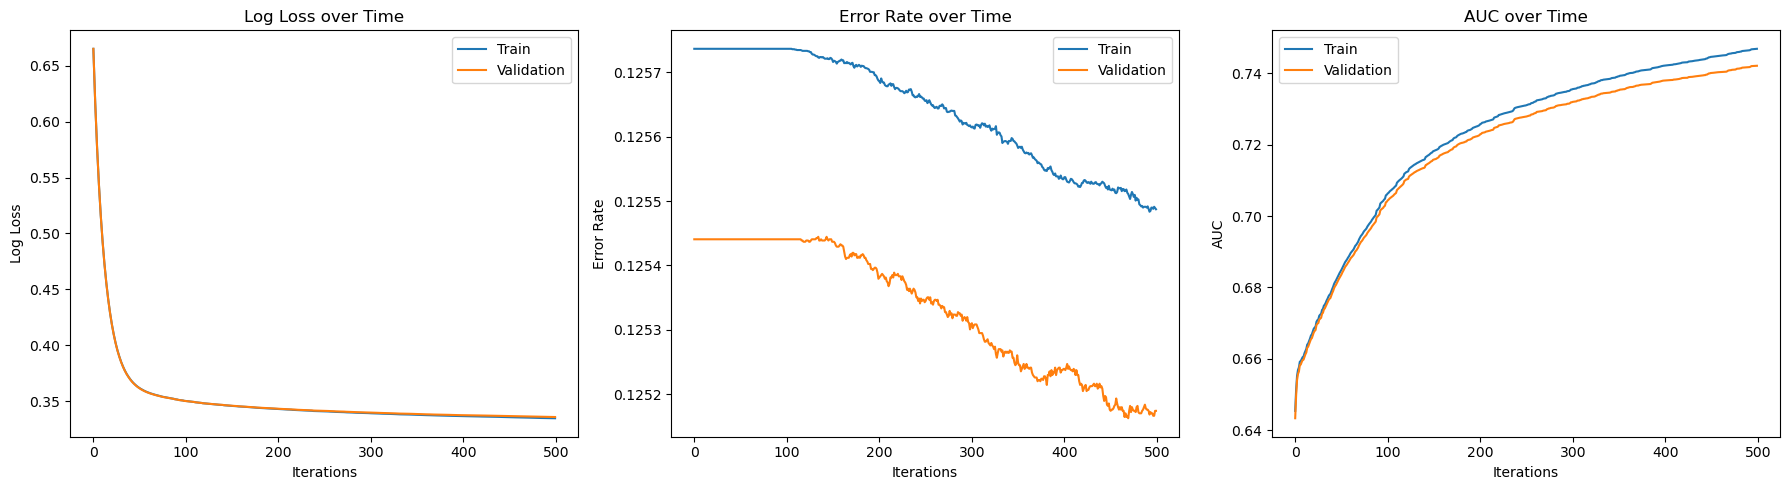

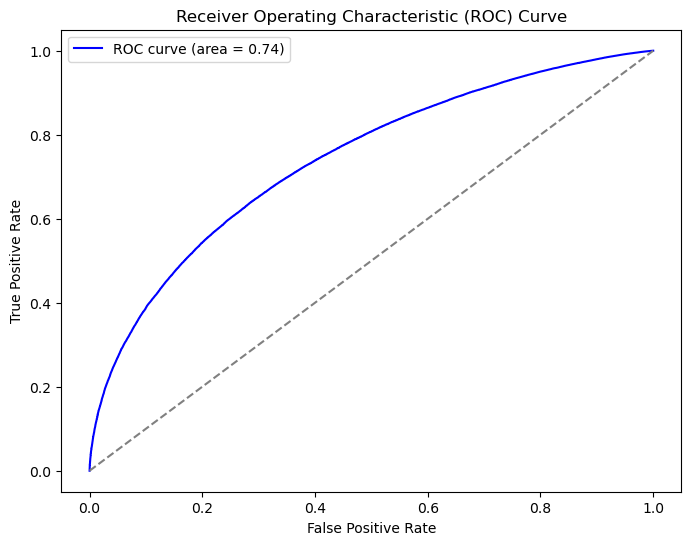

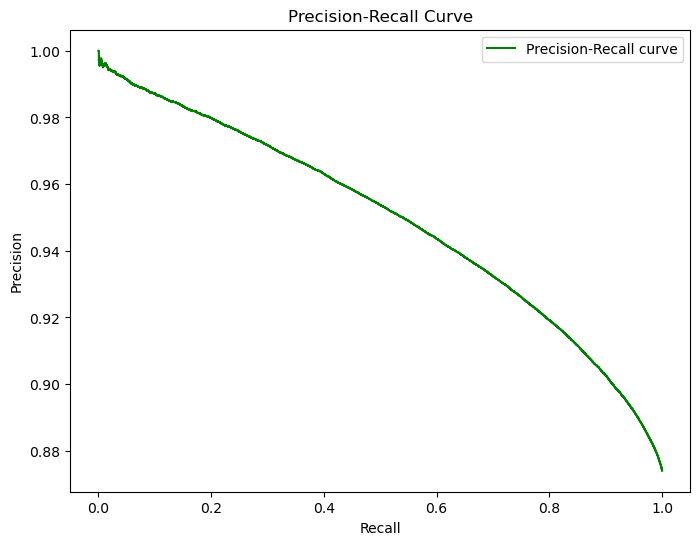

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve


# Retrieve evaluation history
results = xgb_model_rand.evals_result()

# Extract epochs
epochs = len(results["validation_1"]["mlogloss"])  # Use validation set
x_axis = range(0, epochs)

# Create figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot Log Loss
axs[0].plot(x_axis, results["validation_0"]["mlogloss"], label="Train")
axs[0].plot(x_axis, results["validation_1"]["mlogloss"], label="Validation")
axs[0].set_title("Log Loss over Time")
axs[0].set_xlabel("Iterations")
axs[0].set_ylabel("Log Loss")
axs[0].legend()

# Plot Error Rate
axs[1].plot(x_axis, results["validation_0"]["merror"], label="Train")
axs[1].plot(x_axis, results["validation_1"]["merror"], label="Validation")
axs[1].set_title("Error Rate over Time")
axs[1].set_xlabel("Iterations")
axs[1].set_ylabel("Error Rate")
axs[1].legend()

# Plot AUC
axs[2].plot(x_axis, results["validation_0"]["auc"], label="Train")
axs[2].plot(x_axis, results["validation_1"]["auc"], label="Validation")
axs[2].set_title("AUC over Time")
axs[2].set_xlabel("Iterations")
axs[2].set_ylabel("AUC")
axs[2].legend()

plt.tight_layout()
plt.show()

# Generate ROC Curve
y_pred_prob = xgb_model_rand.predict_proba(X_test_rand)[:, 1]
fpr, tpr, _ = roc_curve(y_test_rand, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Generate Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_rand, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions
y_train_pred = xgb_model_rand.predict(X_train_rand)
y_val_pred = xgb_model_rand.predict(X_val_rand)
y_test_pred = xgb_model_rand.predict(X_test_rand)

# Compute accuracy metrics
accuracy_train = accuracy_score(y_train_rand, y_train_pred)
accuracy_val = accuracy_score(y_val_rand, y_val_pred)
accuracy_test = accuracy_score(y_test_rand, y_test_pred)

# Compute precision, recall, and F1-score for validation set
precision_val = precision_score(y_val_rand, y_val_pred, average="weighted")
recall_val = recall_score(y_val_rand, y_val_pred, average="weighted")
f1_val = f1_score(y_val_rand, y_val_pred, average="weighted")

# Display results
accuracy_results = {
    "Train Accuracy": accuracy_train,
    "Validation Accuracy": accuracy_val,
    "Test Accuracy": accuracy_test,
    "Validation Precision": precision_val,
    "Validation Recall": recall_val,
    "Validation F1-score": f1_val
}

accuracy_results


{'Train Accuracy': 0.8745126771080671,
 'Validation Accuracy': 0.8748259446935668,
 'Test Accuracy': 0.8742028474050945,
 'Validation Precision': 0.8377367628498861,
 'Validation Recall': 0.8748259446935668,
 'Validation F1-score': 0.8181102100279295}

## Result Interpretation:
![SHAP Summary Plot](Result.png)

In [46]:
# Get feature importance scores
feature_importance = xgb_model_rand.get_booster().get_score(importance_type="weight")

# Convert to DataFrame for better readability
importance_df = pd.DataFrame(
    feature_importance.items(),
    columns=["Feature", "Importance"]
).sort_values(by="Importance", ascending=False)

print(importance_df.to_string())

                       Feature  Importance
35            earliest_cr_line      1484.0
31                   loan_amnt      1175.0
6                  installment      1073.0
34        mo_sin_old_rev_tl_op      1050.0
44          mo_sin_old_il_acct       778.0
14                  annual_inc       606.0
48                         dti       538.0
4              fico_range_high       506.0
27                  emp_length       483.0
51             tot_hi_cred_lim       419.0
54        acc_open_past_24mths       413.0
30                     bc_util       397.0
1               bc_open_to_buy       373.0
19                     purpose       330.0
45            total_rev_hi_lim       311.0
32              total_bc_limit       284.0
15       mths_since_recent_inq       248.0
11            percent_bc_gt_75       238.0
52                     il_util       234.0
42                    all_util       234.0
40              pct_tl_nvr_dlq       232.0
18        mths_since_recent_bc       221.0
46         

## LLM-Assisted Feature Engineering Model

In [47]:
import pickle
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

# Load dataset (Temporal Split)

# with open("train_val_test_time.pkl", "rb") as f:
#    X_train_time, X_val_time, X_test_time, y_train_time, y_val_time, y_test_time = pickle.load(f)

# print("Data (Time) successfully loaded!")

# Load dataset (Random Split)
with open("train_val_test_LLM.pkl", "rb") as f:
    X_train_rand, X_val_rand, X_test_rand, y_train_rand, y_val_rand, y_test_rand = pickle.load(f)

print("Data (Random) successfully loaded!")

Data (Random) successfully loaded!


In [48]:
import xgboost as xgb
import numpy as np

# Calculate class imbalance for proper weighting
class_counts = np.bincount(y_train_rand)
print(f"Class distribution: {class_counts}")
# scale_pos_weight gives more weight to the minority class (defaults)
scale_pos_weight = class_counts[0] / class_counts[1]
print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")

# Initialize XGBoost classifier with evaluation enabled
xgb_model_rand = xgb.XGBClassifier(
    objective="multi:softmax",  
    num_class=len(y_train_rand.unique()),  
    tree_method="hist",  
    enable_categorical=True,  
    use_label_encoder=False,  
    reg_alpha=5,  
    reg_lambda=2,  
    learning_rate=0.05,  
    max_depth=4,  
    min_child_weight=3,  
    n_estimators=500,  
    early_stopping_rounds=450,  
    eval_metric=["mlogloss", "merror", "auc"],
    scale_pos_weight=scale_pos_weight,
)

# ✅ Train the model with evaluation enabled
xgb_model_rand.fit(
    X_train_rand, y_train_rand,
    eval_set=[(X_train_rand, y_train_rand), (X_val_rand, y_val_rand)],  # Use train & validation set
    verbose=True  # Show progress
)

print("✅ Model training complete with evaluation results.")

Class distribution: [ 196672 1367486]
Calculated scale_pos_weight: 0.14


/Users/jiaxuanliu/anaconda3/envs/math170/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:06:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:0.66523	validation_0-merror:0.12574	validation_0-auc:0.64155	validation_1-mlogloss:0.66520	validation_1-merror:0.12544	validation_1-auc:0.64167
[1]	validation_0-mlogloss:0.63999	validation_0-merror:0.12574	validation_0-auc:0.64633	validation_1-mlogloss:0.63994	validation_1-merror:0.12544	validation_1-auc:0.64619
[2]	validation_0-mlogloss:0.61708	validation_0-merror:0.12574	validation_0-auc:0.65375	validation_1-mlogloss:0.61701	validation_1-merror:0.12544	validation_1-auc:0.65334
[3]	validation_0-mlogloss:0.59627	validation_0-merror:0.12574	validation_0-auc:0.65451	validation_1-mlogloss:0.59618	validation_1-merror:0.12544	validation_1-auc:0.65401
[4]	validation_0-mlogloss:0.57729	validation_0-merror:0.12574	validation_0-auc:0.65505	validation_1-mlogloss:0.57719	validation_1-merror:0.12544	validation_1-auc:0.65441
[5]	validation_0-mlogloss:0.55998	validation_0-merror:0.12574	validation_0-auc:0.65698	validation_1-mlogloss:0.55985	validation_1-merror:0.12544	valid

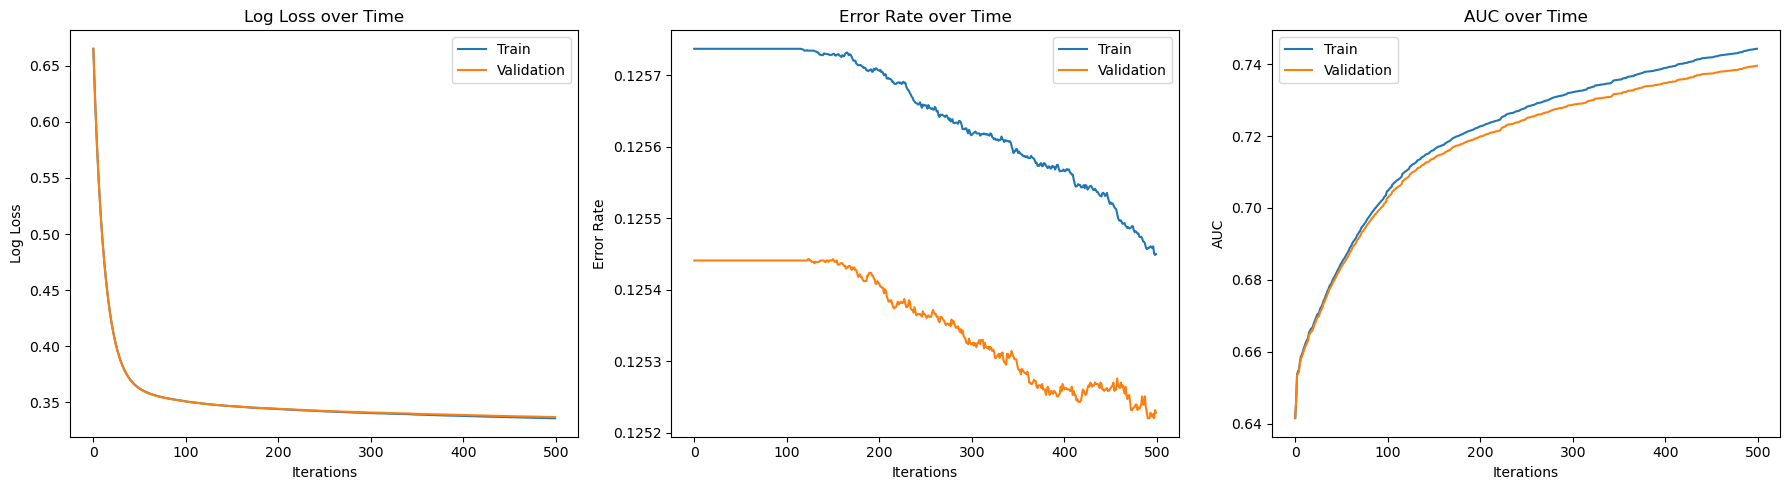

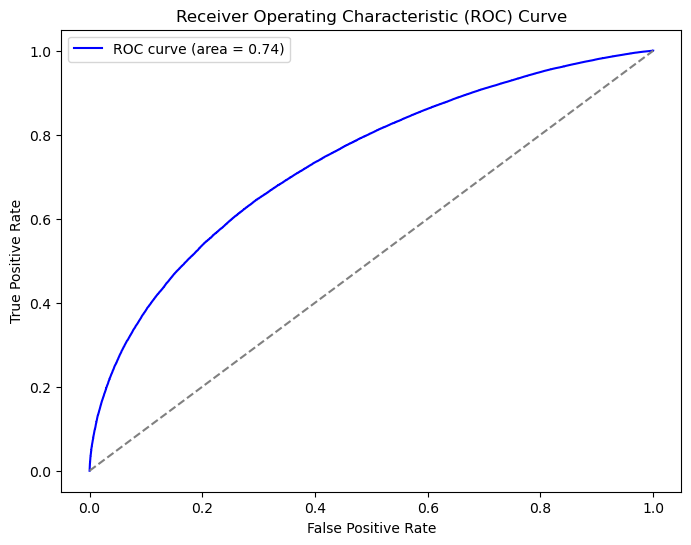

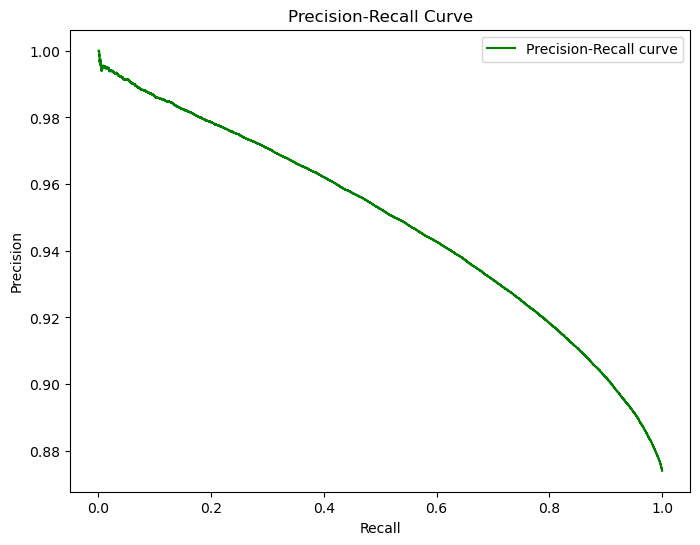

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve


# Retrieve evaluation history
results = xgb_model_rand.evals_result()

# Extract epochs
epochs = len(results["validation_1"]["mlogloss"])  # Use validation set
x_axis = range(0, epochs)

# Create figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot Log Loss
axs[0].plot(x_axis, results["validation_0"]["mlogloss"], label="Train")
axs[0].plot(x_axis, results["validation_1"]["mlogloss"], label="Validation")
axs[0].set_title("Log Loss over Time")
axs[0].set_xlabel("Iterations")
axs[0].set_ylabel("Log Loss")
axs[0].legend()

# Plot Error Rate
axs[1].plot(x_axis, results["validation_0"]["merror"], label="Train")
axs[1].plot(x_axis, results["validation_1"]["merror"], label="Validation")
axs[1].set_title("Error Rate over Time")
axs[1].set_xlabel("Iterations")
axs[1].set_ylabel("Error Rate")
axs[1].legend()

# Plot AUC
axs[2].plot(x_axis, results["validation_0"]["auc"], label="Train")
axs[2].plot(x_axis, results["validation_1"]["auc"], label="Validation")
axs[2].set_title("AUC over Time")
axs[2].set_xlabel("Iterations")
axs[2].set_ylabel("AUC")
axs[2].legend()

plt.tight_layout()
plt.show()

# Generate ROC Curve
y_pred_prob = xgb_model_rand.predict_proba(X_test_rand)[:, 1]
fpr, tpr, _ = roc_curve(y_test_rand, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Generate Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_rand, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [52]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions
y_train_pred = xgb_model_rand.predict(X_train_rand)
y_val_pred = xgb_model_rand.predict(X_val_rand)
y_test_pred = xgb_model_rand.predict(X_test_rand)

# Compute accuracy metrics
accuracy_train = accuracy_score(y_train_rand, y_train_pred)
accuracy_val = accuracy_score(y_val_rand, y_val_pred)
accuracy_test = accuracy_score(y_test_rand, y_test_pred)

# Compute precision, recall, and F1-score for validation set
precision_val = precision_score(y_val_rand, y_val_pred, average="weighted")
recall_val = recall_score(y_val_rand, y_val_pred, average="weighted")
f1_val = f1_score(y_val_rand, y_val_pred, average="weighted")

# Display results
accuracy_results = {
    "Train Accuracy": accuracy_train,
    "Validation Accuracy": accuracy_val,
    "Test Accuracy": accuracy_test,
    "Validation Precision": precision_val,
    "Validation Recall": recall_val,
    "Validation F1-score": f1_val
}

accuracy_results

{'Train Accuracy': 0.8745503970826477,
 'Validation Accuracy': 0.8747722416789097,
 'Test Accuracy': 0.8741759959492661,
 'Validation Precision': 0.8370516802728,
 'Validation Recall': 0.8747722416789097,
 'Validation F1-score': 0.8177829598058118}

## Baseline model Training (Temporal)


In [14]:
# Initialize XGBoost classifier with evaluation enabled
xgb_model_time = xgb.XGBClassifier(
    objective="multi:softmax",  
    num_class=len(y_train_time.unique()),  
    tree_method="hist",  
    enable_categorical=True,  
    use_label_encoder=False,  
    reg_alpha=5,  
    reg_lambda=2,  
    learning_rate=0.05,  
    max_depth=4,  
    min_child_weight=3,  
    n_estimators=500,  
    early_stopping_rounds=450,  
    eval_metric=["mlogloss", "merror", "auc"],
    scale_pos_weight=scale_pos_weight,
)

# ✅ Train the model with evaluation enabled
xgb_model_time.fit(
    X_train_time, y_train_time,
    eval_set=[(X_train_time, y_train_time), (X_val_time, y_val_time)],  # Use train & validation set
    verbose=True  # Show progress
)

print("✅ Model training complete with evaluation results.")

NameError: name 'y_train_time' is not defined

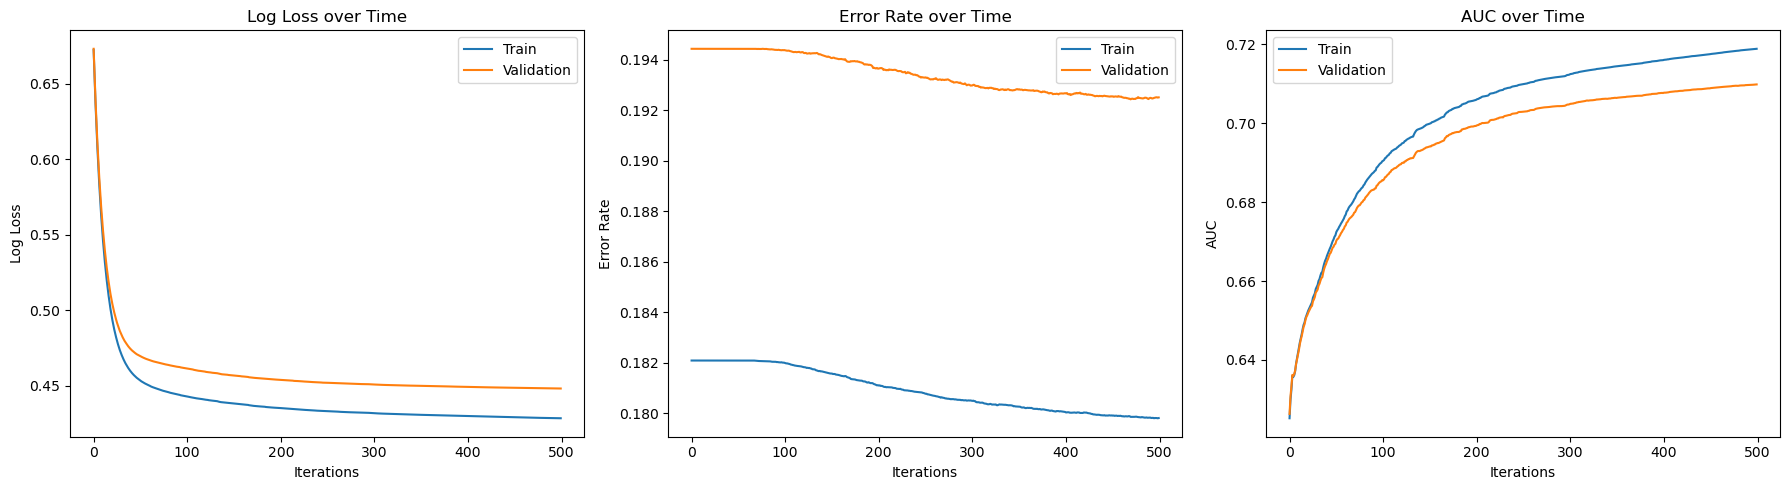

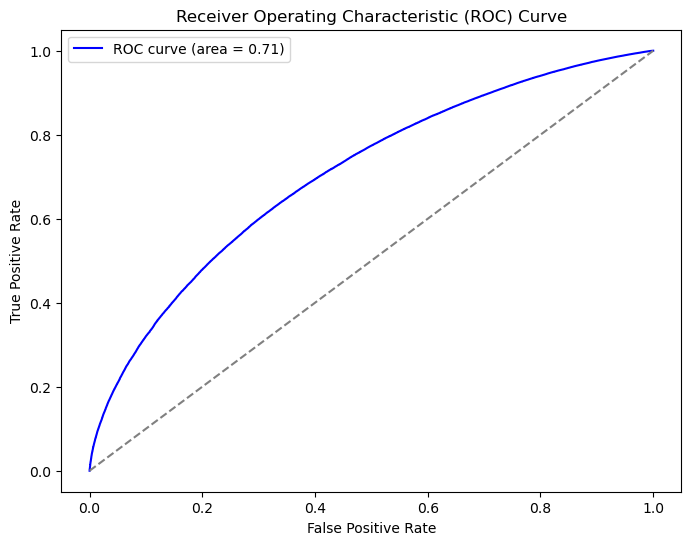

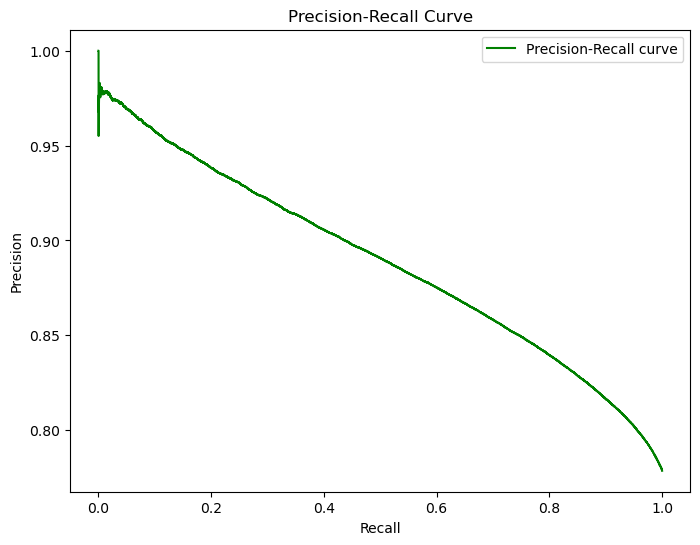

In [30]:
# Retrieve evaluation history
results = xgb_model_time.evals_result()

# Extract epochs
epochs = len(results["validation_1"]["mlogloss"])  # Use validation set
x_axis = range(0, epochs)

# Create figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot Log Loss
axs[0].plot(x_axis, results["validation_0"]["mlogloss"], label="Train")
axs[0].plot(x_axis, results["validation_1"]["mlogloss"], label="Validation")
axs[0].set_title("Log Loss over Time")
axs[0].set_xlabel("Iterations")
axs[0].set_ylabel("Log Loss")
axs[0].legend()

# Plot Error Rate
axs[1].plot(x_axis, results["validation_0"]["merror"], label="Train")
axs[1].plot(x_axis, results["validation_1"]["merror"], label="Validation")
axs[1].set_title("Error Rate over Time")
axs[1].set_xlabel("Iterations")
axs[1].set_ylabel("Error Rate")
axs[1].legend()

# Plot AUC
axs[2].plot(x_axis, results["validation_0"]["auc"], label="Train")
axs[2].plot(x_axis, results["validation_1"]["auc"], label="Validation")
axs[2].set_title("AUC over Time")
axs[2].set_xlabel("Iterations")
axs[2].set_ylabel("AUC")
axs[2].legend()

plt.tight_layout()
plt.show()

# Generate ROC Curve
y_pred_prob = xgb_model_time.predict_proba(X_test_time)[:, 1]
fpr, tpr, _ = roc_curve(y_test_time, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Generate Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_time, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [31]:
# Make predictions
y_train_pred = xgb_model_time.predict(X_train_time)
y_val_pred = xgb_model_time.predict(X_val_time)
y_test_pred = xgb_model_time.predict(X_test_time)

# Compute accuracy metrics
accuracy_train = accuracy_score(y_train_time, y_train_pred)
accuracy_val = accuracy_score(y_val_time, y_val_pred)
accuracy_test = accuracy_score(y_test_time, y_test_pred)

# Compute precision, recall, and F1-score for validation set
precision_val = precision_score(y_val_time, y_val_pred, average="weighted")
recall_val = recall_score(y_val_time, y_val_pred, average="weighted")
f1_val = f1_score(y_val_time, y_val_pred, average="weighted")

# Display results
accuracy_results = {
    "Train Accuracy": accuracy_train,
    "Validation Accuracy": accuracy_val,
    "Test Accuracy": accuracy_test,
    "Validation Precision": precision_val,
    "Validation Recall": recall_val,
    "Validation F1-score": f1_val
}

accuracy_results


{'Train Accuracy': 0.8201813878600402,
 'Validation Accuracy': 0.8074926374169694,
 'Test Accuracy': 0.780796556245835,
 'Validation Precision': 0.7627440285970241,
 'Validation Recall': 0.8074926374169694,
 'Validation F1-score': 0.7352729377992375}

In [32]:
# Get feature importance scores
feature_importance = xgb_model_time.get_booster().get_score(importance_type="weight")

# Convert to DataFrame for better readability
importance_df = pd.DataFrame(
    feature_importance.items(),
    columns=["Feature", "Importance"]
).sort_values(by="Importance", ascending=False)

print(importance_df.to_string())

                       Feature  Importance
16                   loan_amnt      2001.0
15                 installment      1804.0
9                   emp_length       806.0
2                   annual_inc       637.0
7                          dti       600.0
6                      bc_util       549.0
10             fico_range_high       491.0
51            total_rev_hi_lim       485.0
50                     purpose       484.0
47              total_bc_limit       449.0
0         acc_open_past_24mths       432.0
19        mo_sin_old_rev_tl_op       425.0
48             tot_hi_cred_lim       362.0
18          mo_sin_old_il_acct       339.0
24        mths_since_recent_bc       330.0
52            earliest_cr_line       307.0
38              pct_tl_nvr_dlq       292.0
45            percent_bc_gt_75       287.0
5               bc_open_to_buy       270.0
39                   total_acc       255.0
22                    mort_acc       248.0
46  total_il_high_credit_limit       227.0
25       mt